<mark><font color=black size=6 face=雅黑>数据集为蚂蚁和蜜蜂的彩色图片<font><mark>

# 配置环境

In [1]:
# 导入包
import os
import json
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, utils
import numpy as np


%matplotlib inline

In [2]:
# 使用GPU训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


# 构建模型

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        # 用nn.Sequential()将网络打包成一个模块，精简代码
        self.features = nn.Sequential(  # 卷积层提取图像特征
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True),                                  # 直接修改覆盖原值，节省运算内存
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[48, 27, 27]
            nn.Conv2d(48, 128, kernel_size=5, padding=2),           # output[128, 27, 27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 13, 13]
            nn.Conv2d(128, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),          # output[128, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 6, 6]
        )
        self.classifier = nn.Sequential(       # 全连接层对图像分类
            nn.Dropout(p=0.5),                 # Dropout 随机失活神经元，默认比例为0.5
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
        if init_weights:
            self._initialize_weights()
    # 前向传播过程
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)    # 展平后再传入全连接层
        x = self.classifier(x)
        return x
    
    # 网络权重初始化，实际上 pytorch 在构建网络时会自动初始化权重
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):                                                # 若是卷积层
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # 用（何）kaiming_normal_法初始化权重
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)                                        # 初始化偏重为0
            elif isinstance(m, nn.Linear):                                             # 若是全连接层
                nn.init.normal_(m.weight, 0, 0.01)                                     # 正态分布初始化
                nn.init.constant_(m.bias, 0)                                           # 初始化偏重为0

# 对数据预处理

## 预处理方式

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),    # 随机裁剪，再缩放成 224×224
                                 transforms.RandomHorizontalFlip(),    # 水平方向随机翻转，概率为 0.5, 即一半的概率翻转, 一半的概率不翻转
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),## 导入训练集
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

## 导入训练集

In [5]:
# 获取图像数据集的路径
data_root = os.path.abspath(os.getcwd())  # get data root path
image_path = os.path.join(data_root, "data_set", "animal")  # flower data set path
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

# 导入训练集并进行预处理
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# 按batch_size分批次加载训练集
batch_size = 32
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
# print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

## 导入验证集

In [6]:
# 导入验证集并进行预处理
validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                        transform=data_transform["val"])
val_num = len(validate_dataset)

# 加载验证集
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=4, shuffle=False,
                                              num_workers=0)

print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))

using 244 images for training, 153 images for validation.


In [7]:
# test_data_iter = iter(validate_loader)
# test_image, test_label = test_data_iter.next()

# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# print(' '.join('%5s' % cla_dict[test_label[j].item()] for j in range(4)))
# imshow(utils.make_grid(test_image))

## 将类别写入json文件

In [8]:
# 字典，类别：索引{'ants':0, 'bees':1}
animal_list = train_dataset.class_to_idx

# 将 animal_list 中的 key 和 val 调换位置
cla_dict = dict((val, key) for key, val in animal_list.items())

# 将 cla_dict 写入 json 文件中
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices_animal.json', 'w') as json_file:
    json_file.write(json_str)

# 训练

## 实例化网络，并配置相关参数

In [9]:
net = AlexNet(num_classes=2, init_weights=True)   # 实例化网络（输出类型为2，初始化权重）
net.to(device)                                     # 分配网络到指定的设备（GPU/CPU）训练
loss_function = nn.CrossEntropyLoss()              # 交叉熵损失
# pata = list(net.parameters())
optimizer = optim.Adam(net.parameters(), lr=0.0002)# 优化器（训练参数，学习率）

epochs = 10
save_path = './AlexNet02.pth'
best_acc = 0.0
train_steps = len(train_loader)
val_acc=[]           #每一轮的验证精度存下来

## 开始训练

In [10]:
for epoch in range(epochs):
    ########################################## train ###############################################
    net.train()                         # 训练过程中开启 Dropout
    running_loss = 0.0                  # 每个 epoch 都会对 running_loss  清零
    time_start = time.perf_counter()    # 对训练一个 epoch 计时
    train_bar = tqdm(train_loader, file=sys.stdout)  #添加一个进度提示信息
    for step, data in enumerate(train_bar):          # 遍历训练集，step从0开始计算
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)
    print('%f s' % (time.perf_counter()-time_start))
    print()
    ########################################### validate ###########################################
    net.eval()    # 验证过程中关闭 Dropout
    acc = 0.0     # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]     # 以output中值最大位置对应的索引（标签）作为预测输出
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))
    val_acc.append(val_accurate)
    # 保存准确率最高的那次网络参数
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

train epoch[1/10] loss:0.684: 100%|██████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]
6.596311 s

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.24it/s]
[epoch 1] train_loss: 0.702  val_accuracy: 0.458
train epoch[2/10] loss:0.688: 100%|██████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.40it/s]
1.820134 s

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.95it/s]
[epoch 2] train_loss: 0.691  val_accuracy: 0.556
train epoch[3/10] loss:0.676: 100%|██████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]
1.566047 s

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.12it/s]
[epoch 3] train_loss: 0.687  val_accuracy: 0.523
train epoch[4/10] loss:0.696: 100%|██████████████████████████████████████████████████████| 8/8 [0

## 画出每轮验证结果折线图

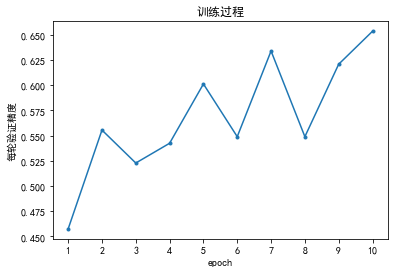

In [11]:
x = np.arange(10)
plt.title('训练过程')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('epoch')  # x轴标题
plt.ylabel('每轮验证精度')  # y轴标题
plt.xticks(np.arange(1,11,step=1))
plt.plot(x+1, val_acc, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
# print(val_acc)

# 网上随意找一张图测试

class: ants         prob: 0.833
class: bees         prob: 0.167


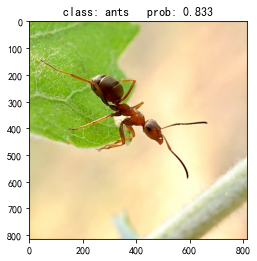

In [12]:
#预处理
data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load image
img_path = "data_set/animal/mayi.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension# 网上随意找一张图测试
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices_animal.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = AlexNet(num_classes=2).to(device)

# load model weights
weights_path = "./AlexNet02.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()